## Training Example

SSAI-3D supports sparse fine-tuning and inference on 3D microscopy data to achieve high-quality axial resolution restoration on a specific dataset. In this notebook, we provide two examples datasets for sparse fine-tuning.

#### Data Preparation

- For all usages, please prepare your data in a single tiff format, with shape `(depth, width, height)`.

- Move your single-stack 3D dataset to `~/SSAI-3D/demo`. For example, it can be [mouse brain neurons](https://drive.google.com/file/d/1p3CUWhaSJXAA_9k8p4nRrhjBmbegQ-vJ/view?usp=sharing) or [mouse liver](https://www.nature.com/articles/s41592-018-0216-7#data-availability).

#### Pre-trained Model Checkpoints

- Download the [pre-trained model](https://drive.google.com/file/d/14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X/view) and place the file in ```~/SSAI-3D/demo/experiments/pretrained_models```.
  
- **[Optional]** For applications requiring denoising, put the denoising model under the same directory. For example, we have trained a [denoising model](https://drive.google.com/file/d/1Lkg5a8xtjze7cKitdMl8bIY38cLAIojT/view?usp=sharing) using self-owned data.


#### Preparations
import needed packages.

In [1]:
from basicsr.trainer import Surgeon, SurgeonTrainer
from basicsr.data import restore_volume, semi_synthetic_creation, \
     generate_raw_data, generate_zs_dataset, adjust_contrast, denoised_semi_synthetic_creation
from basicsr.model_train import trainer_train, restore
from easydict import EasyDict
import numpy as np 
import os
import tifffile

/Users/ramachandrank/Documents/Tbpl/SSAI-3D/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramachandrank/Documents/Tbpl/SSAI-3D/.venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ramachandrank/Documents/Tbpl/SSAI-3D/.venv/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /Users/ramachandrank/Documents/Tbpl/SSAI-3D/.venv/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <F008E7E7-AB21-3358-8168-A868137DB04F> /Users/ramachandrank/Documents/Tbpl/

In [2]:
image_path = './oct.tif'

Load anisotropic raw stack, generated semi-synthetic dataset, as well as zero-shot dataset

In [3]:
raw_tif_pth, kernel_num, project_depth, data_pth = \
    image_path, 3, 5, './demo_dataset'

In [15]:
# raw_data = tifffile.imread(raw_tif_pth)
# print(raw_data.shape)
# for i in range(len(raw_data)):
#     tifffile.imwrite(f"./images_in_directions/0_z/{i}.tiff", raw_data[i])

(900, 500, 500)


In [5]:
semi_synthetic_creation(raw_tif_pth = raw_tif_pth, save_pth = data_pth, \
    kernel_num = kernel_num, project_depth = project_depth, downsample_rate = 5,  rotation = False)
generate_raw_data(raw_pth = raw_tif_pth, save_pth= data_pth, dr = 5)
generate_zs_dataset(data_pth)

uint16
xy_len:500, xz_len:900, yz_len:500


Obtain zero-shot metrics as well as the relative performance of each layer within the network via a pre-trained surgeon network

In [5]:
configs = EasyDict({
    'model_path' : f'./experiments/pretrained_models/NAFNet-REDS-width64.pth',
    'lq_pth': os.path.join(data_pth, 'zs_lq'),
    'gt_pth': os.path.join(data_pth, 'zs_gt'),
    'lr': 1e-4
})
operation = Surgeon(configs)
operation.get_zeroshot_information()
surgeon_trainer = SurgeonTrainer()
elementwise_input = operation.input_dict.copy()
rank = surgeon_trainer.forward_all(elementwise_input)

Disable distributed.
none
rank: 0
ws: 1


2025-02-03 02:48:14,952 INFO: Model [ImageRestorationModel] is created.


 load net keys <built-in method keys of dict object at 0x31e87c140>
.. cosineannealingLR
grad_norm
snip
grasp
fisher


/Users/ramachandrank/Documents/Tbpl/SSAI-3D/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


plain
synflow
None weight loaded


#### Training the network

In [6]:
trainer_train(rank, data_pth)

Disable distributed.


2025-02-03 02:48:45,730 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+78b8f21
	PyTorch: 1.11.0
	TorchVision: 0.14.1
2025-02-03 02:48:45,730 INFO: 
  name: demo_neurons
  model_type: ImageRestorationModel
  scale: 1
  num_gpu: 1
  manual_seed: 10
  datasets:[
    train:[
      name: reds-train
      type: PairedImageDataset
      dataroot_gt: ./demo_dataset/gt
      dataroot_lq: ./demo_dataset/

none


2025-02-03 02:48:46,121 INFO: Dataset PairedImageDataset - reds-train is created.
2025-02-03 02:48:46,121 INFO: Training statistics:
	Number of train images: 3237
	Dataset enlarge ratio: 1
	Batch size per gpu: 1
	World size (gpu number): 1
	Require iter number per epoch: 3237
	Total epochs: 1; iters: 1000.
2025-02-03 02:48:46,123 INFO: Dataset PairedImageDataset - reds-val300-test is created.
2025-02-03 02:48:46,123 INFO: Number of val images/folders in reds-val300-test: 0


AssertionError: Torch not compiled with CUDA enabled

#### Resolution Restoration

In [6]:
data_pth = './demo_dataset'
in_pth_xz = os.path.join(data_pth, 'test_xz')
in_pth_yz = os.path.join(data_pth, 'test_yz')
out_root = './results'
out_pth_xz = os.path.join(out_root, 'test_xz')
out_pth_yz = os.path.join(out_root, 'test_yz')
# Currently set batch size to 1 to be compatible with smaller GPUs, can be adjusted as needed to speed up inference.
restore(input_pth = in_pth_xz,\
        output_pth = out_pth_xz,\
        model_pth =  '../experiments/demo_neurons/models/net_g_latest.pth')

restore(input_pth = in_pth_yz,\
        output_pth = out_pth_yz,\
        model_pth =  '../experiments/demo_neurons/models/net_g_latest.pth')

Disable distributed.
none


2024-10-26 12:27:10,482 INFO: Loading NAFNetLocal model from ../experiments/demo_neurons/models/net_g_latest.pth.
2024-10-26 12:27:10,671 INFO: Model [ImageRestorationModel] is created.


 load net keys <built-in method keys of collections.OrderedDict object at 0x7a924b46ca40>


100%|██████████| 500/500 [00:28<00:00, 17.35it/s]

Disable distributed.


none


2024-10-26 12:27:40,350 INFO: Loading NAFNetLocal model from ../experiments/demo_neurons/models/net_g_latest.pth.
2024-10-26 12:27:40,543 INFO: Model [ImageRestorationModel] is created.


 load net keys <built-in method keys of collections.OrderedDict object at 0x7a924b1b20c0>


100%|██████████| 400/400 [00:29<00:00, 13.52it/s]


In [7]:
import tifffile
tmp = tifffile.imread(image_path)
tmp.dtype.name

'uint16'

Average from XZ and YZ directions

In [8]:
xz, yz, av = restore_volume(in_pth_xz, out_pth_xz, out_pth_yz)

# Add to script in lab PC
tifffile.imwrite(os.path.join(out_root, '3D.tiff'), av)

image = Image.open(os.path.join(out_root, '3D.tiff'))

# Convert to grayscale
gray_image = image.convert('L')

# Save the grayscale image
gray_image.save(os.path.join(out_root, '3D_grayscale.tiff'))

100%|██████████| 400/400 [00:00<00:00, 1834.88it/s]


#### Visualization

NameError: name 'av' is not defined

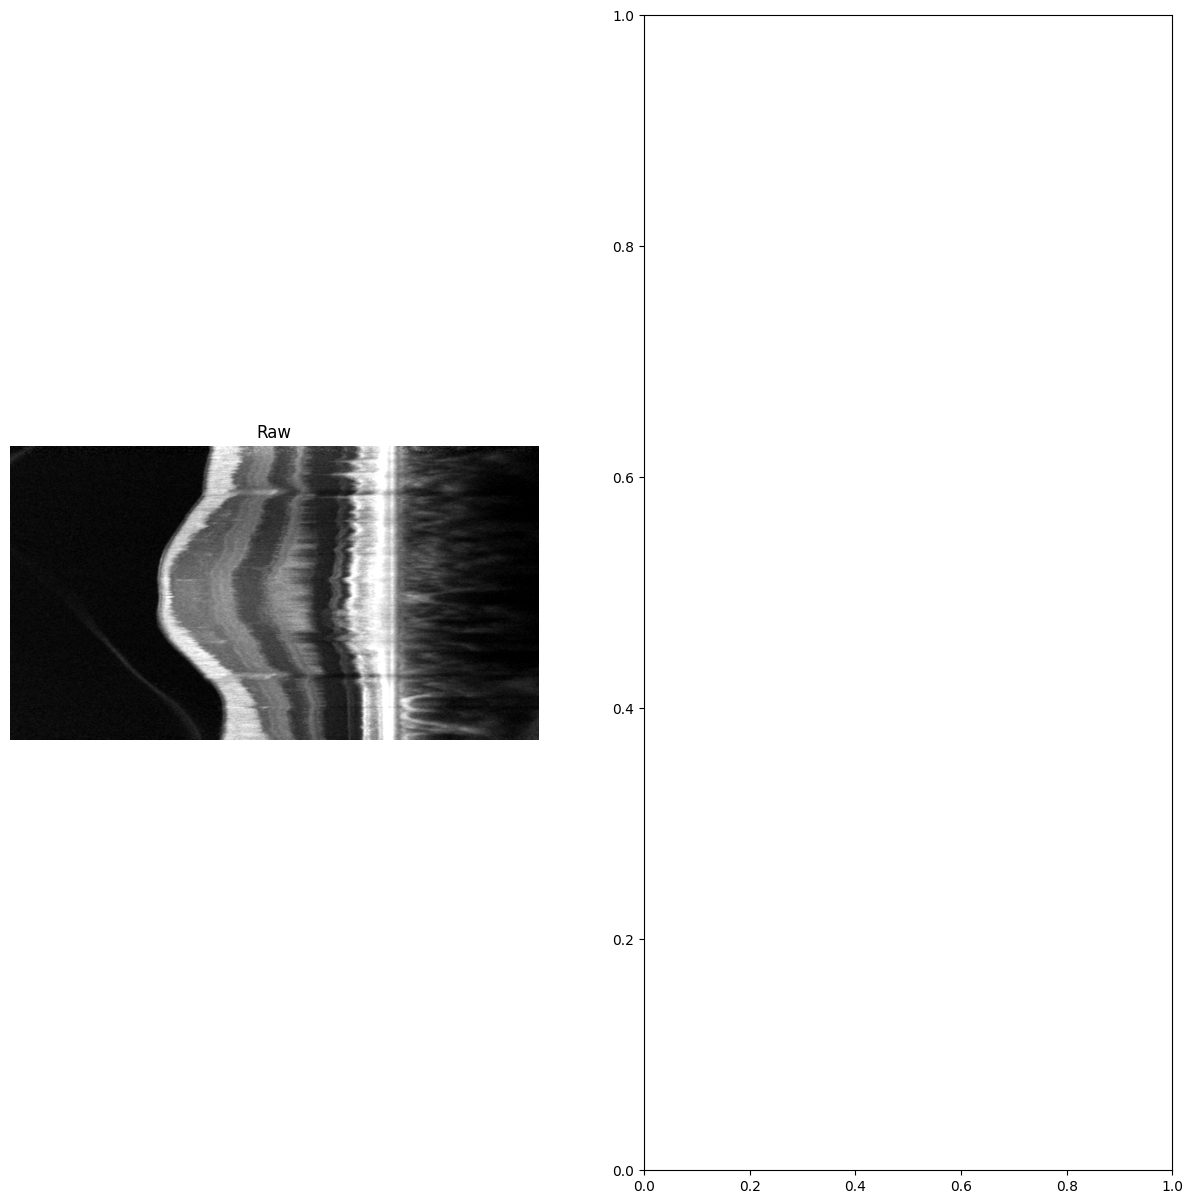

In [19]:
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
raw_tif_pth = image_path
raw = tifffile.imread(raw_tif_pth)

slice_idx = 200
depth = 20
figs, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(adjust_contrast(cv2.resize(np.mean(raw[:, :, slice_idx:slice_idx + depth], -1), (900, 500*1))), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Raw')
axs[1].imshow(adjust_contrast(np.amax(av[slice_idx:slice_idx + depth], 0)), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Recovered')
plt.show()


## Resolution Enhancement with Denoising

##### First create denoised semi-synthetic data

In [18]:
from basicsr.trainer import Surgeon, SurgeonTrainer
from basicsr.data import restore_volume, semi_synthetic_creation, \
     generate_raw_data, generate_zs_dataset, adjust_contrast, denoised_semi_synthetic_creation
from basicsr.model_train import trainer_train, restore
from easydict import EasyDict
import os
raw_tif_pth, kernel_num, project_depth, data_pth = \
    image_path, 3, 5, './demo_dataset'

In [19]:
semi_synthetic_creation(raw_tif_pth = raw_tif_pth, save_pth = data_pth, \
    kernel_num = kernel_num, project_depth = project_depth, downsample_rate = 5,  rotation = False)

generate_raw_data(raw_pth = raw_tif_pth, save_pth= data_pth, dr = 5)
generate_zs_dataset(data_pth)


uint16


In [2]:
restore(input_pth='./demo_dataset/test_xy',output_pth='./demo_dataset/denoised_gt',model_pth= './experiments/pretrained_models/denoising_model.pth', denoise = True) 
denoised_semi_synthetic_creation(input_pth = './demo_dataset/denoised_gt',output_pth = './demo_dataset/',
    kernel_num = 3, downsample_rate = 5,  rotation = False)

Disable distributed.
none
 load net keys <built-in method keys of collections.OrderedDict object at 0x7f91cf91bcc0>


Current net - loaded net:
  ending.bias
  ending.weight
Loaded net - current net:
  ending.lower.bias
  ending.lower.weight
  ending.prediction.bias
  ending.prediction.weight
  ending.upper.bias
  ending.upper.weight
Size different, ignore [intro.weight]: crt_net: torch.Size([64, 3, 3, 3]); load_net: torch.Size([64, 5, 3, 3])
2024-09-20 17:03:44,522 INFO: Model [ImageRestorationModel] is created.
100%|██████████| 80/80 [00:09<00:00,  8.84it/s]


In [ ]:
trainer_train(rank, './demo_dataset/denoised_gt_train', './demo_dataset/denoised_lq_train')

In [ ]:
data_pth = './demo_dataset'
in_pth_xz = os.path.join(data_pth, 'test_xz')
in_pth_yz = os.path.join(data_pth, 'test_yz')
out_root = './demo_dataset/denoised_results'
out_pth_xz = os.path.join(out_root, 'test_xz')
out_pth_yz = os.path.join(out_root, 'test_yz')
# Currently set batch size to 1 to be compatible with smaller GPUs, can be adjusted as needed to speed up inference.
restore(input_pth = in_pth_xz,\
        output_pth = out_pth_xz,\
        model_pth = './experiments/pretrained_models/denoising_model.pth', denoise = True)
        # './experiments/pretrained_models/denoising_model.pth', denoise = True)

restore(input_pth = in_pth_yz,\
        output_pth = out_pth_yz,\
        model_pth =  './experiments/pretrained_models/denoising_model.pth', denoise = True)


data_pth = './demo_dataset/denoised_results'
in_pth_xz = os.path.join(data_pth, 'test_xz')
in_pth_yz = os.path.join(data_pth, 'test_yz')
out_root = './results/deconved_denoised_results'
out_pth_xz = os.path.join(out_root, 'test_xz')
out_pth_yz = os.path.join(out_root, 'test_yz')
restore(input_pth = in_pth_xz,\
        output_pth = out_pth_xz,\
        model_pth =  '../experiments/demo_neurons/models/net_g_latest.pth')

restore(input_pth = in_pth_yz,\
        output_pth = out_pth_yz,\
        model_pth =  '../experiments/demo_neurons/models/net_g_latest.pth')


In [3]:
xz, yz, av = restore_volume(in_pth_xz, out_pth_xz, out_pth_yz)

100%|██████████| 400/400 [00:04<00:00, 95.85it/s] 


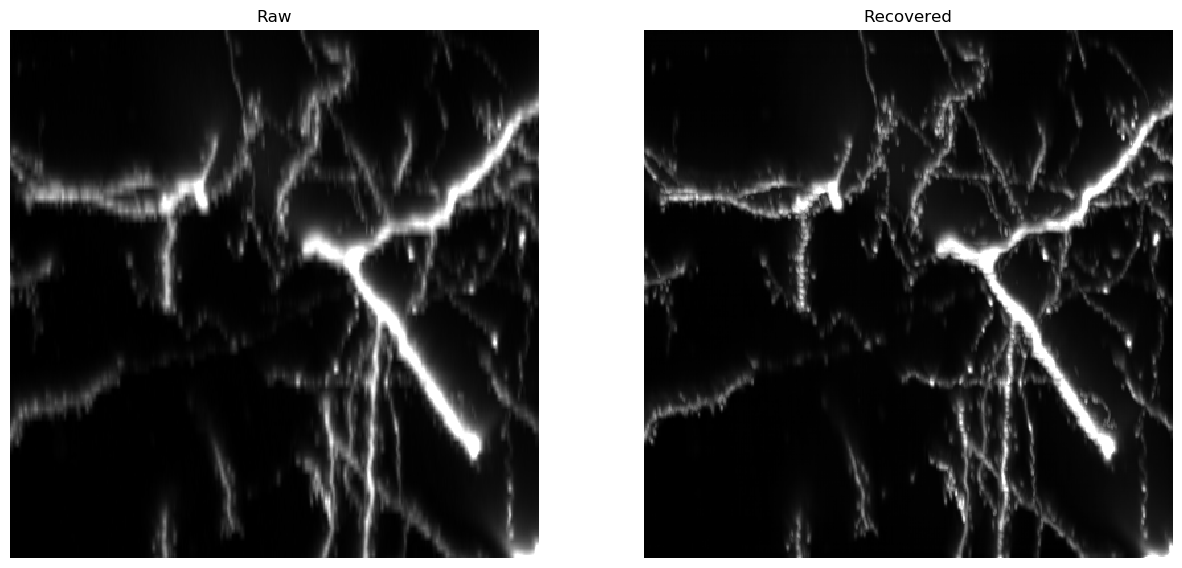

In [13]:
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
raw_tif_pth = image_path
raw = tifffile.imread(raw_tif_pth)

slice_idx = 100
depth = 200
figs, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(adjust_contrast(cv2.resize(np.amax(raw[:, :, slice_idx:slice_idx + depth], -1), (1153, 194*5))[:400, :400]), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Raw')
axs[1].imshow(adjust_contrast(np.amax(av[slice_idx:slice_idx + depth], 0)[:400, :400]), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Recovered')
plt.show()